In [1]:
import json
import os
import glob
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(10,6)}, font_scale=1.8)

In [2]:
# Define params
firstlevel_label = 'first_level_bySession'
analysis_name = 'analysis-r2byRegion'
parcels = 1000
model_names = ['RidgeCV']

# Define paths
proj_dir = os.path.abspath(os.path.join(os.getcwd(), '../..'))
firstlevel_dir = os.path.join(proj_dir, 'Y_data', firstlevel_label)
results_dir = os.path.join(proj_dir, 'model_outputs', firstlevel_label, analysis_name)

In [3]:
def get_avg_metric(res_df, metric='r2_byMap', new_col='r2_byMap_mean'):
    ## Compute an average across splits and tasks, for each subject (and for null models also across iterations)

    res_df[new_col] = np.nan
    for row_idx in range(res_df.shape[0]):
        metric_all_iterations = res_df[metric].iloc[row_idx]
        avg_vals = []
        for iteration in metric_all_iterations:
            avg_vals.append(np.mean(iteration))
        # Average across iterations (for non-null models, the number of iterations is 1) 
        res_df[new_col].iloc[row_idx] = np.mean(avg_vals)
    return res_df

In [4]:
## Aggregate results into one df

res_df = None
for model_name in model_names:
    model_output_dir = os.path.join(results_dir, model_name)
    
    # Get list of dicts from the pkl files
    dict_list = []
    pkls = sorted(glob.glob(os.path.join(model_output_dir, '*')))
    for fname in pkls:
        with open(fname, 'rb') as f:
            d = pickle.load(f)
        # if null, make explicit in feature set label 
        num_parcels = list(d.keys())[0]
        feature_set = list(d[num_parcels].keys())[0]
        model_name = list(d[num_parcels][feature_set].keys())[0]
        sub = list(d[num_parcels][feature_set][model_name].keys())[0]
        d[num_parcels][feature_set][model_name][sub]['seed'] = 0
        if 'shuffle' in fname:
            feature_set_new = fname.split('_')[-3]
            seed = fname.split('_')[-2].split('-')[-1]
            d[num_parcels][feature_set_new] = d[num_parcels].pop(feature_set)
            d[num_parcels][feature_set_new][model_name][sub]['seed'] = seed
        dict_list.append(d) 

    # Aggregate dicts into a df
    for d in dict_list:
        num_parcels = list(d.keys())[0]
        feature_set = list(d[num_parcels].keys())[0]
        model_name = list(d[num_parcels][feature_set].keys())[0]
        sub = list(d[num_parcels][feature_set][model_name].keys())[0]
        sub_dict = d[num_parcels][feature_set][model_name][sub]
        metrics = list(sub_dict.keys())
        metrics = [i for i in metrics if i != 'preds']            
        
        if res_df is None:
            cols = ['parcels', 'feature_set', 'model_name', 'sub']
            cols.extend(metrics)
            res_df = pd.DataFrame(columns=cols)

        row = [num_parcels, feature_set, model_name, sub]
        for m in metrics:
            if m in ['r2_byMap', 'r2_byRegion']:
                item = sub_dict[m][0]
            else:
                item = sub_dict[m]
            if m not in ['preds']:
                row.append(item)
        res_df = res_df.append(pd.Series(row, index=res_df.columns), ignore_index=True)

res_df = get_avg_metric(res_df, metric='r2_byMap', new_col='r2_byMap_mean')
res_df = get_avg_metric(res_df, metric='r2_byRegion', new_col='r2_byRegion_mean')

/Users/walters/opt/anaconda3/envs/multitask_env/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


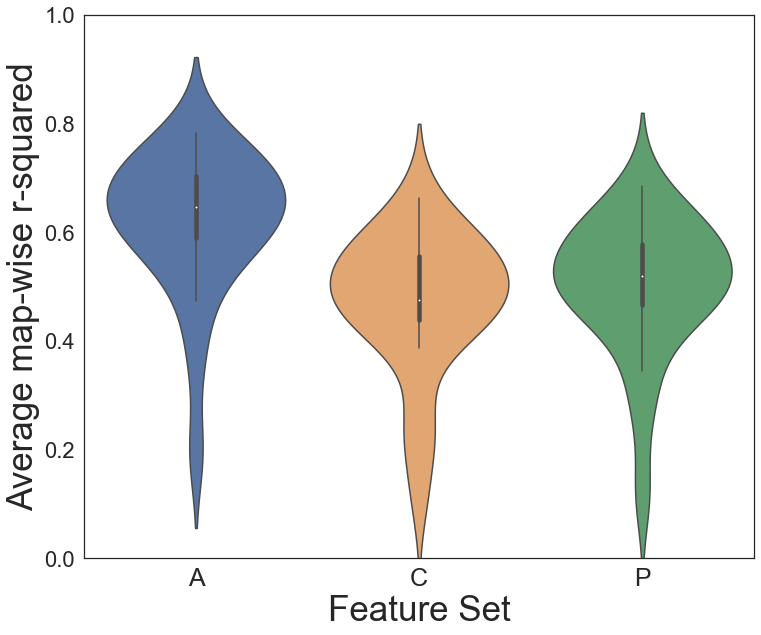

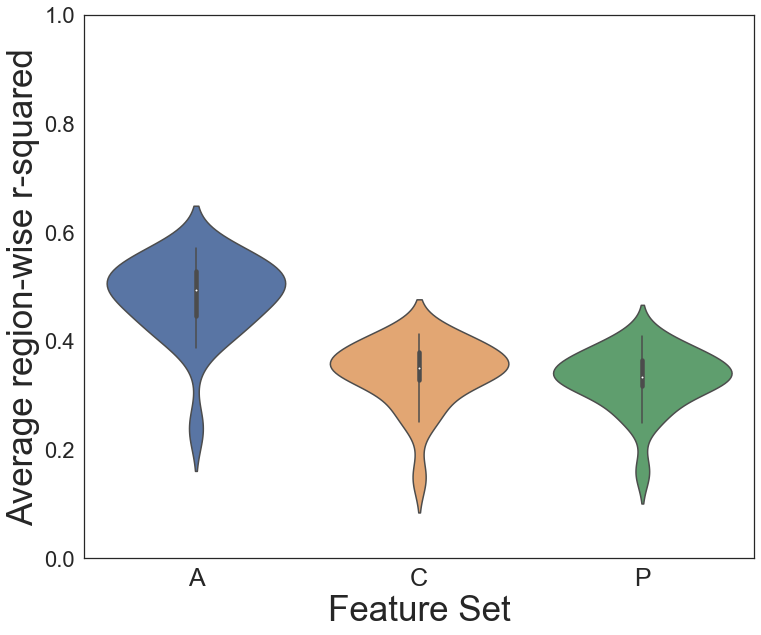

In [5]:
## Plot map-wise and region-wise r-squared

sns.set(style='white', font_scale=2)

df = res_df
filetype = 'pdf'

fig_dir = 'figures/subject-specific-models'
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

order = ['all', 'cognitive', 'perceptualmotor']
xticklabels = ['A', 'C', 'P']
palette = ['b','sandybrown','g']

labelsize = 35
ticksize = 25

# Map-wise r2 (average across all 1892 predictions, per subject)
metric = 'r2_byMap_mean'
plt.figure(figsize=(12,10))
ax = sns.violinplot(x='feature_set', y=metric, data=df, order=order, scale='width', palette=palette, widths=10)
plt.xlabel('Feature Set', fontsize=labelsize)
plt.ylabel('Average map-wise r-squared', fontsize=labelsize);
ax.set_xticklabels(xticklabels, fontsize=ticksize)
#plt.savefig(os.path.join(fig_dir, 'avg_map-correlations.%s' % filetype))
plt.ylim(0, 1);

# Region-wise r2 (average across all 1892 predictions, per subject)
metric = 'r2_byRegion_mean'
plt.figure(figsize=(12,10))
ax = sns.violinplot(x='feature_set', y=metric, data=df, order=order, scale='width', palette=palette, widths=10)
plt.xlabel('Feature Set', fontsize=labelsize)
plt.ylabel('Average region-wise r-squared', fontsize=labelsize);
ax.set_xticklabels(xticklabels, fontsize=ticksize)
#plt.savefig(os.path.join(fig_dir, 'avg_map-correlations.%s' % filetype))
plt.ylim(0, 1);

In [6]:
df.groupby('feature_set').mean()

,r2_byMap_mean,r2_byRegion_mean
feature_set,,
all,0.617400,0.480225
cognitive,0.471126,0.340593
perceptualmotor,0.500413,0.328921


In [7]:
df.groupby('feature_set').std()

,r2_byMap_mean,r2_byRegion_mean
feature_set,,
all,0.131595,0.073114
cognitive,0.127895,0.060101
perceptualmotor,0.125470,0.054417
